## Different implementation of a CUDA kernel using Numba cuda.jit.
Below a few different implementation of a cunvolution kernel are benchmarked. None of them go as fast as a cuSignal implementation.
- Direct (no fany stuff)
- Strided
- Strided + streaming 
- SIMT (shfl_down_sync) + streaming 

### Profiles
Pmplementations can the profile using nvidia's Visual Profiler using
- nvprof --print-gpu-trace python implementation.py
- nvprof -f -o prof.nvvp python implementation.py
- nvprof -f --analysis-metrics -o prof.nvvp python implementation.py

### Sources
- Source: https://docs.nvidia.com/cuda/profiler-users-guide/index.html#abstract
- Source: https://gist.github.com/sonots/5abc0bccec2010ac69ff74788b265086

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import cupy as cp
from numba import cuda, float64

from bootstrap import default


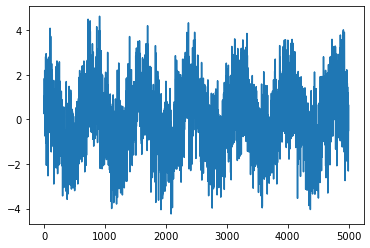

In [2]:
signal, references, window = default()

plt.plot(signal[0,:])

In [3]:
# A simple direct impementation of a convolution kernel in Numba using CUDA
@cuda.jit('void(f8[:,:], f8[:], f8[:], f8[:,:])')
def cuda_simple(signal, ref, window, result):
    i, j = cuda.grid(2) 
    N, M = signal.shape
    Q = window.size
    if (i >= N) or (j >= M): 
        return

    delta = Q//2 

    sum = float64(0)
    for k in range(Q):
        j_k = j - k + delta
        if (j_k >= 0) and (j_k < M):  
            sum += window[k] * ref[j_k]*signal[i,j_k]
    result[i, j] = sum
    
def init_gpu(references, window):
    """ Initialize GPU memory 
    Store the reference and window data in the gpu memory and return the handles. 
    
    Arguments:
    - reference: A (M, k) numpy array (np.float64) containing the reference(s) for convolution. Each column in reference will generate a seperate demodulation result per column in signal. 
	- windows: A (q) numpy array (np.float64) containing the window data. 
    Returns:
    - gpuR, gpuW: references to the memory on the GPU
    """
    gpuR = cuda.to_device(references)
    gpuW = cuda.to_device(window)
    return gpuR, gpuW

def go_cuda(signal, gpuR, gpuW):
    """ Run demodulation on the GPU
    First store the reference and window data on the GPU using the init_gpu() function. The object returned are 
    required for this function.

    Returns:
    - A (M, N) numpy array (np.float64) buffer for the average of the convolution result along the second dimension of the signal data. This can be considered as the demodulation result for each demodulation channel. 
    """
    N, k = signal.shape
    M = gpuR.shape[0]
    results = np.zeros((M, N))
    griddim = (N//32 + 1, k//32 + 1)
    for i in range(M):
        # Allocate memory on the GPU
        buffer = cuda.device_array_like(signal)

        # Transfer the signal data to the GPU
        gpuS = cuda.to_device(signal)

        # We apply our convolution to our image:
        cuda_simple[griddim,(32,32)](gpuS, gpuR[i,:], gpuW, buffer)

        # Take the 'integrant' (We should changed to to a GPU operation as well?)
        results[i,:] = np.mean(buffer.copy_to_host(), axis=1)

    return results

Numba simple GPU:
688 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


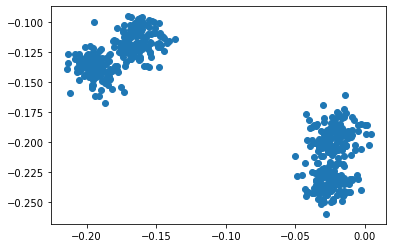

In [4]:
# Run demodulation using a simple Numba GPU implementation
gpuR, gpuW = init_gpu(references, window)

averages = go_cuda(signal, gpuR, gpuW)
plt.plot(*averages, 'o')

print("Numba simple GPU:")
%timeit go_cuda(signal, gpuR, gpuW)

In [5]:
# A strided impementation of a convolution kernel in Numba using CUDA
def init_gpu(references, window):
    """ Initialize GPU memory 
    Store the reference and window data in the gpu memory and return the handles. 
    
    Arguments:
    - reference: A (M, k) numpy array (np.float64) containing the reference(s) for convolution. Each column in reference will generate a seperate demodulation result per column in signal. 
	- windows: A (q) numpy array (np.float64) containing the window data. 
    Returns:
    - gpuR, gpuW: references to the memory on the GPU
    """
    gpuR = cuda.to_device(references)
    gpuW = cuda.to_device(window)
    return gpuR, gpuW

def go_cuda(signal, gpuR, gpuW, griddim=None, blockdim=None):
    """ Run demodulation on the GPU
    First store the reference and window data on the GPU using the init_gpu() function. The object returned are 
    required for this function.

    Returns:
    - A (M, N) numpy array (np.float64) buffer for the average of the convolution result along the second dimension of the signal data. This can be considered as the demodulation result for each demodulation channel. 
    """
    N, k = signal.shape
    M = gpuR.shape[0]
    results = np.zeros((M, N))

    if blockdim is None:
        blockdim = (8,8)

    if griddim is None:
        griddim = (N//blockdim[0] + 1, k//blockdim[1] + 1)

    # Allocate memory on the GPU
    buffer = cuda.device_array(signal.shape, np.float64)

    # Transfer the signal data to the GPU
    gpuS = cuda.to_device(signal)

    for i in range(M):
        # We apply our convolution to our image:
        strided_convolve[griddim, blockdim](gpuS, gpuR[i,:], gpuW, buffer)

        # Take the 'integrant' (We should changed to to a GPU operation as well?)
        results[i,:] = np.mean(buffer.copy_to_host(), axis=1)

    return results

@cuda.jit('void(f8[:,:], f8[:], f8[:], f8[:,:])')
def strided_convolve(signal, ref, window, result):
    i, j = cuda.grid(2) 
    N, M = signal.shape
    Q = window.size
    if (i >= N) or (j >= M): 
        return
    
    sum = float64(0) 
    xstride, ystride = cuda.gridsize(2)
    for num_x in range(i, result.shape[0], xstride):
        for num_y in range(j, result.shape[1], ystride):
            delta = Q//2 

            sum = 0
            for k in range(Q):
                j_k = num_y - k + delta
                if (j_k >= 0) and (j_k < M):  
                    sum += window[k] * ref[j_k]*signal[num_x, j_k]
            result[num_x, num_y] = sum



Numba strided GPU:
238 ms ± 731 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


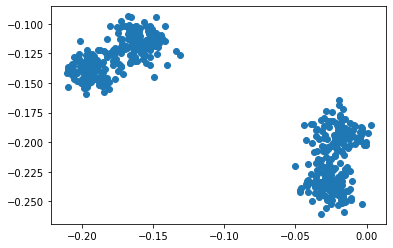

In [6]:
# Run demodulation using a strided Numba GPU implementation
signal, references, window = default(N=501, p=5001)

gpuR, gpuW = init_gpu(references, window)

griddim = (128, 128)
averages = go_cuda(signal, gpuR, gpuW, blockdim=(2,2))
plt.plot(*averages, 'o')

print("Numba strided GPU:")
%timeit go_cuda(signal, gpuR, gpuW)

In [7]:
# A strided + streaming impementation of a convolution kernel in Numba using CUDA
def init_gpu(references, window):
    """ Initialize GPU memory 
    Store the reference and window data in the gpu memory and return the handles. 
    
    Arguments: 
    - reference: A (M, k) numpy array (np.float64) containing the reference(s) for convolution. Each column in reference will generate a seperate demodulation result per column in signal. 
	- windows: A (q) numpy array (np.float64) containing the window data. 
    Returns:
    - gpuR, gpuW: references to the memory on the GPU
    """
    gpuR = cuda.to_device(references)
    gpuW = cuda.to_device(window)
    return gpuR, gpuW

@cuda.jit('void(f8[:], f8[:,:], f8[:], f8[:,:])')
def convolve(signal, ref, window, result):
    i, j = cuda.grid(2) 
    C, p = ref.shape
    W = window.size
    if (i >= C) or (j >= p): 
        return
    
    sum = float64(0) 
    xstride, ystride = cuda.gridsize(2)
    for num_x in range(i, result.shape[0], xstride):
        for num_y in range(j, result.shape[1], ystride):
            delta = W//2 

            sum = 0
            for k in range(W):
                j_k = num_y - k + delta
                if (j_k >= 0) and (j_k < p):  
                    sum += window[k] * ref[num_x, j_k]*signal[j_k]
            result[num_x, num_y] = sum

def go_cuda(signal, gpuR, gpuW, griddim=None, blockdim=None):
    """ Run demodulation on the GPU
    First store the reference and window data on the GPU using the init_gpu() function. The object returned are 
    required for this function.

    Returns:
    - A (M, N) numpy array (np.float64) buffer for the average of the convolution result along the second dimension of the signal data. This can be considered as the demodulation result for each demodulation channel. 
    """
    N, k = signal.shape
    C, k = gpuR.shape

    if blockdim is None:
        blockdim = (8,8)

    if griddim is None:
        griddim = (C//blockdim[0] + 1, k//blockdim[1] + 1)

    # ==========
    stream = cuda.stream()

    gpuS = cuda.to_device(signal, stream=stream)
    buffer = cuda.device_array((C, k), np.float64, stream=stream)

    output = np.zeros((C,N))
    for i in range(N):
        convolve[griddim, blockdim, stream](gpuS[i,:], gpuR, gpuW, buffer)
        cpbuffer = cp.asarray(buffer)
        output[:,i] = cp.asnumpy(cp.mean(cpbuffer, axis=1))

    return output


Numba strided + streaming GPU:
966 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


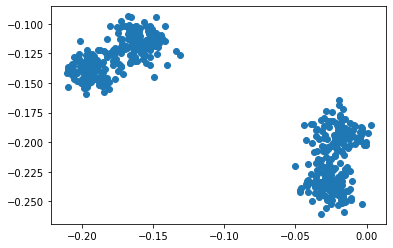

In [8]:
# Run demodulation using a strided + streaming Numba GPU implementation
N, k = signal.shape
gpuR, gpuW = init_gpu(references, window)

griddim = (128, 128)
averages = go_cuda(signal, gpuR, gpuW)
plt.plot(*averages, 'o')

print("Numba strided + streaming GPU:")
%timeit go_cuda(signal, gpuR, gpuW)

In [9]:
# A SMIT + streaming impementation of a convolution kernel in Numba using CUDA
from numba import f8, f4, u4

@cuda.jit('f8(f8, u4)', device=True)
def reduce_warp(value, mask):
    offset = 16 # i.e. WARPSIZE // 2
    while offset:
        value += cuda.shfl_down_sync(mask, value, offset)
        offset //= 2
    return value

@cuda.jit('void(f8[:], f8[:,:], f8[:], f8[:,:])')
def convolve(signal, ref, window, result):
    smem = cuda.shared.array(0, f8)

    i, j = cuda.grid(2) 
    S = signal.size
    W = window.size
    
    Bix = cuda.blockIdx.x   # Block index along the x dimension       -> indexing the signal
    BDx = cuda.blockDim.x   # Number of threads along x               -> Many things
    tix = cuda.threadIdx.x  # x thread id within block [0,blockdim.x) -> indexing the window
    tiy = cuda.threadIdx.y  # y thread id within block [0,blockdim.y) -> indexing of memory
    tif = tix + tiy*BDx     # thread index within a block (flat)      -> indexing lines and shared memory
    
    index = j + tix         # reference and signal index

    value = f8(0)
    if (tix < W) & (index < S):
        value = window[tix] * (ref[Bix, index] * signal[index])
    value = reduce_warp(value, u4(0xffffffff))
    # Reduced sum should be present in the value of all threads with lane index == 0

    # Store the warp reduction in the shared memory
    if tif % 32 == 0:             # For all threads with lane index == 0
        smem[tif // 32] = value   # Flat warp id 
    cuda.syncthreads()  

    # When the blocksize is smaller than a single warp (32), we are done. 
    # In this case we can be very specific about the locations we need
    if (BDx <= 32) and (tix == 0): 
        result[Bix, j] = smem[tiy]

    # Otherwise, take values from the shared memory van reduce.
    # NOTE: maximum number of threads is 1024 which is 32 times a warp (consisting of 32 threads)
    # This means, the warp reductions of 32 warps, fit baxck into a single warp. 
    
    # Disperse the reduction values from the memory over the first threads along the x direction. 
    # All others become 0
    Nwx = (BDx-1)//32 + 1
    if (tix < BDx // 32):
        values = smem[tix + Nwx*tiy]
    else:
        values = 0
    # Perhaps its better to put the index definition outside the if-else block and remove this barrier 
    cuda.syncthreads() 

    # All threads in a first warp along x 
    if tix // 32 == 0:
        value = reduce_warp(value, u4(0xffffffff))
    cuda.syncthreads() 

    if (tix == 0) and (j < S):
        result[Bix, j] = value

def init_gpu(references, window):
    kernel = np.zeros( ((window.size//32+1)*32,) )
    kernel[:window.size] = window

    gpuR = cuda.to_device(references)
    gpuW = cuda.to_device(kernel)
    return gpuR, gpuW

def go_cuda(signal, gpuR, gpuW):
    W = gpuW.size
    N, S = signal.shape
    M = gpuR.shape[0]

    BX, BY = W, min(1024//W, S)
    blockdim = (BX, BY)
    griddim = (M, (S-1)//BY+1)

    # Calculate the size of shared memory required for a block
    smem_size = signal.itemsize * (BX//32 * BY)

    stream = cuda.stream()
    gpuS = cuda.to_device(signal, stream=stream)
    buffer = cuda.device_array((M, S), np.float64, stream=stream)

    #gpuS = cuda.to_device(signal)
    #buffer = cuda.device_array((M, S), np.float64)

    output = np.zeros((M,N))
    for i in range(N):
        convolve[griddim, blockdim, stream, smem_size](gpuS[i,:], gpuR, gpuW, buffer)
        cpbuffer = cp.asarray(buffer)
        output[:,i] = cp.asnumpy(cp.mean(cpbuffer, axis=1))
    stream.synchronize()
    
    return output

    

Numba SMIT + streaimng GPU:
995 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


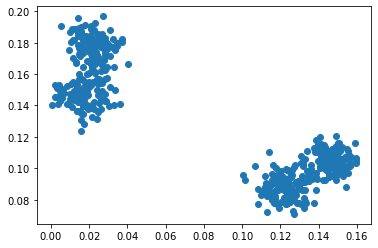

In [10]:
# Run demodulation using a SMIT + streaming Numba GPU implementation
# EXPERIMENTAL! The answer is WRONG!!!
gpuR, gpuW = init_gpu(references, window)

averages = go_cuda(signal, gpuR, gpuW)
plt.plot(*averages, 'o')

print("Numba SMIT + streaimng GPU:")
%timeit go_cuda(signal, gpuR, gpuW)
